# MODELO BASE - SEM GENERO E SEM UTILIZADOR: DUPLA OPTIMIZAÇÃO

# POR ACABAR !!!!!!!!!!

In [15]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import warnings

#warnings.filterwarnings("ignore")

plt.rcParams.update({
    "text.usetex": True,              # If you want to use LaTeX fonts in text
    "font.family": "serif",           # IEEE uses Times New Roman-like fonts
    "font.size": 12,                   # General font size for IEEE format
    "axes.labelsize": 12,              # Axis labels font size
    "legend.fontsize": 11,             # Legend font size
    "xtick.labelsize": 11,             # X-axis tick labels font size
    "ytick.labelsize": 11,             # Y-axis tick labels font size
    "figure.figsize": (5, 5*0.8),
    "savefig.dpi": 900,               # DPI for high-quality PNG/JPEG
})

# Load the data

In [16]:
df_train = pd.read_csv("data/data_train.csv")
df_test = pd.read_csv("data/data_test.csv")

In [17]:
with open("data/data_ids.json") as f:
    ids = json.load(f)

max_movieId = max(ids["moviesIDs"].values())
max_userId = max(ids["userIDs"].values())

# Create a matrix of users and movies
base_matrix = np.zeros((max_movieId + 1, max_userId + 1))
base_matrix.shape

(9633, 385)

# Define functions

In [18]:
# Utility matrix and Binary matrix
from scipy.sparse import lil_matrix

def utility_matrix_AND_binary_matrix(dfTrain, zerosMatrix = base_matrix, jsonIds = ids):
    Y = lil_matrix(zerosMatrix.shape)  # Use sparse matrix format
    R = lil_matrix(zerosMatrix.shape)
    for i, row in dfTrain.iterrows():
        original_movieId, original_userId = int(row["movieId"]), int(row["userId"])
        movieId = jsonIds["moviesIDs"][str(original_movieId)]
        userId = jsonIds["userIDs"][str(original_userId)]
        Y[movieId, userId] = row["rating"]
        R[movieId, userId] = 1
    return Y, R

In [19]:
def cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda):
    """
    Returns the cost and gradient for the collaborative filtering
    Lambda - regularization parameter
    """
        
    # Unfold the params
    X = params[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = params[num_movies*num_features:].reshape(num_users,num_features)
    
    predictions =  X @ Theta.T
    err = (predictions - Y)
    J = 1/2 * np.sum((err**2) * R)
    
    #compute regularized cost function
    reg_X =  Lambda/2 * np.sum(Theta**2)
    reg_Theta = Lambda/2 *np.sum(X**2)
    reg_J = J + reg_X + reg_Theta
    
    # Compute gradient
    X_grad = err*R @ Theta
    Theta_grad = (err*R).T @ X
    grad = np.append(X_grad.flatten(),Theta_grad.flatten())
    
    # Compute regularized gradient
    reg_X_grad = X_grad + Lambda*X
    reg_Theta_grad = Theta_grad + Lambda*Theta
    reg_grad = np.append(reg_X_grad.flatten(),reg_Theta_grad.flatten())
    
    return J, grad, reg_J, reg_grad

In [20]:
def gradientDescent(initial_parameters,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda):
    """
    alpha - learning rate
    Optimize X and Theta
    """
    # unfold the initial parameters (consult function cofiCostFunc)
    X = initial_parameters[:num_movies*num_features].reshape(num_movies,num_features)
    Theta = initial_parameters[num_movies*num_features:].reshape(num_users,num_features)
    
    J_history =[]
    
    for i in range(num_iters):
        #Append into a single vector params X and Theta (see above)
        params = np.append(X.flatten(),Theta.flatten())        
        cost, grad = cofiCostFunc(params, Y, R, num_users, num_movies, num_features, Lambda)[2:]
        
        # unfold grad
        X_grad = grad[:num_movies*num_features].reshape(num_movies,num_features)
        Theta_grad = grad[num_movies*num_features:].reshape(num_users,num_features)
        
        #Update trainable parameters X & Theta applying gradient descent method
        X = X - alpha*X_grad
        
        Theta = Theta - alpha*Theta_grad
        
        J_history.append(cost)
    
    #Append into a single vector paramsFinal the updated X and Theta
    paramsFinal = np.append(X.flatten(),Theta.flatten())
    return paramsFinal , J_history

# Start modelling

- split the df in 8 to do cv

- define num of features to use: 20 because we have 20 diff genres of movies (02 data_vis.ipynb)

In [21]:
# Shuffle the DataFrame randomly and split it into 8 parts
df_shuffled = df_train.sample(frac=1, random_state=42).reset_index(drop=True)
folds = np.array_split(df_shuffled, 8)

# define the number of movies, users and features
num_movies, num_users = base_matrix.shape
num_features = 20

/opt/anaconda3/envs/FAA/lib/python3.10/site-packages/numpy/_core/fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


optimize the hyperparameters of the model using 8cv and minimizing RMSE

In [22]:
"""Lambdas = [0, 5, 6, 7, 8, 10, 13, 15, 20, 25]
alphas = [0.0001, 0.0004, 0.0005, 0.00065, 0.00075, 0.001, 0.0015]
num_iters = 500

combo = 1
results = {}
for Lambda in Lambdas:
    for alpha in alphas:
        print(f"Combination {combo} of {len(Lambdas)*len(alphas)} with ({Lambda}, {alpha}):", end=" ") 
        combo += 1

        avg_RMSE = 0
        for exclude_index in range(8):
            merged_df = pd.concat([part for i, part in enumerate(folds) if i != exclude_index])

            # Create the utility matrix and the binary matrix
            Y, R = utility_matrix_AND_binary_matrix(merged_df)
            Y, R = Y.toarray(), R.toarray()

            # Define the initial parameters
            X = np.random.normal(loc=0, scale=0.3, size=(num_movies, num_features))
            Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
            params = np.append(X.flatten(),Theta.flatten())

            # Apply gradient descent
            param, jhist = gradientDescent(params,Y,R,num_users,num_movies,num_features,alpha,num_iters,Lambda)

            # Unfold the final parameters
            X = param[:num_movies*num_features].reshape(num_movies,num_features)
            Theta = param[num_movies*num_features:].reshape(num_users,num_features)

            # Predict all ratings of num_users for num_movies
            p = X @ Theta.T

            # Compute the RMSE
            RMSE = 0
            for i, row in folds[exclude_index].iterrows():
                movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
                userId_matrix = ids["userIDs"][str(int(row["userId"]))]
                RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2
            RMSE = np.sqrt(RMSE/len(folds[exclude_index]))
            print(f"CV{exclude_index+1}: {RMSE:.1f}", end=", ")
            avg_RMSE += RMSE/8
        
        results[(Lambda, alpha)] = avg_RMSE
        print("")"""
"" # dont forget to remove results = results_stored 

''

In [23]:
results_stored = {(0, 0.0001): np.float64(1.4072155396070718),
 (0, 0.0004): np.float64(1.329441099136409),
 (0, 0.0005): np.float64(1.331832787510863),
 (0, 0.00065): np.float64(1.3538502353564172),
 (0, 0.00075): np.float64(1.3670562968234878),
 (0, 0.001): np.float64(1.399231907427166),
 (0, 0.0015): np.float64(1.5442264523301559),
 (5, 0.0001): np.float64(1.3916450159275262),
 (5, 0.0004): np.float64(1.2595971542706506),
 (5, 0.0005): np.float64(1.2615322851054707),
 (5, 0.00065): np.float64(1.2657603187182012),
 (5, 0.00075): np.float64(1.2660834153538214),
 (5, 0.001): np.float64(1.269235919121385),
 (5, 0.0015): np.float64(1.4281701904101156),
 (6, 0.0001): np.float64(1.3880787118397724),
 (6, 0.0004): np.float64(1.258036975590825),
 (6, 0.0005): np.float64(1.2562210608559057),
 (6, 0.00065): np.float64(1.2599197078509734),
 (6, 0.00075): np.float64(1.2651038137438524),
 (6, 0.001): np.float64(1.2720538908635541),
 (6, 0.0015): np.float64(1.4239594315407202),
 (7, 0.0001): np.float64(1.3870968421582952),
 (7, 0.0004): np.float64(1.257085789794418),
 (7, 0.0005): np.float64(1.2587336007461594),
 (7, 0.00065): np.float64(1.2610897726698738),
 (7, 0.00075): np.float64(1.261454195272955),
 (7, 0.001): np.float64(1.2686882792502265),
 (7, 0.0015): np.float64(1.4261456547158486),
 (8, 0.0001): np.float64(1.3875208059964381),
 (8, 0.0004): np.float64(1.2597372777982643),
 (8, 0.0005): np.float64(1.2608664814669375),
 (8, 0.00065): np.float64(1.2610153010253864),
 (8, 0.00075): np.float64(1.2661986155111122),
 (8, 0.001): np.float64(1.268767379532215),
 (8, 0.0015): np.float64(1.427841860737669),
 (10, 0.0001): np.float64(1.3949851967912197),
 (10, 0.0004): np.float64(1.268535044726058),
 (10, 0.0005): np.float64(1.2670007102849818),
 (10, 0.00065): np.float64(1.2689003396161314),
 (10, 0.00075): np.float64(1.2720601240889786),
 (10, 0.001): np.float64(1.272805366635899),
 (10, 0.0015): np.float64(1.430976705513454),
 (13, 0.0001): np.float64(1.409880100149872),
 (13, 0.0004): np.float64(1.287353201723529),
 (13, 0.0005): np.float64(1.2895666959086132),
 (13, 0.00065): np.float64(1.287528675568315),
 (13, 0.00075): np.float64(1.2884323185219257),
 (13, 0.001): np.float64(1.2901560328175044),
 (13, 0.0015): np.float64(1.4377377704540053),
 (15, 0.0001): np.float64(1.4169037535407742),
 (15, 0.0004): np.float64(1.3068190187900375),
 (15, 0.0005): np.float64(1.3055199617280704),
 (15, 0.00065): np.float64(1.3052878260700018),
 (15, 0.00075): np.float64(1.3045831918120192),
 (15, 0.001): np.float64(1.3033551677801687),
 (15, 0.0015): np.float64(1.4692610601649292),
 (20, 0.0001): np.float64(1.4504394250236607),
 (20, 0.0004): np.float64(1.355463913004609),
 (20, 0.0005): np.float64(1.3543914597866222),
 (20, 0.00065): np.float64(1.354246478082104),
 (20, 0.00075): np.float64(1.3534108633821984),
 (20, 0.001): np.float64(1.3523986904932916),
 (20, 0.0015): np.float64(1.4931745110271646),
 (25, 0.0001): np.float64(1.4892201242500134),
 (25, 0.0004): np.float64(1.4100417419616782),
 (25, 0.0005): np.float64(1.4092118984960929),
 (25, 0.00065): np.float64(1.4086409821798012),
 (25, 0.00075): np.float64(1.408302702030173),
 (25, 0.001): np.float64(1.4075217187634002),
 (25, 0.0015): np.float64(1.5297191660022733)}
#results_stored
results = results_stored.copy()

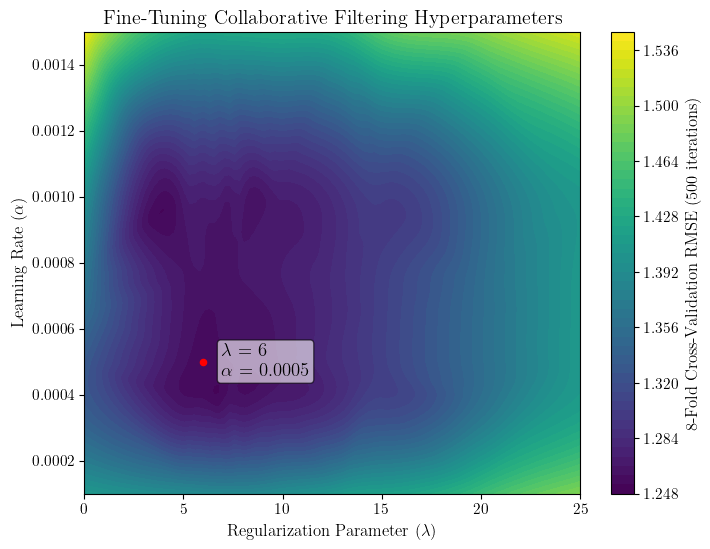

In [24]:
from scipy.interpolate import griddata

# Extract x, y, and z values
points = np.array(list(results.keys()))
x, y = points[:, 0], points[:, 1]
z = np.array(list(results.values()))

# Create a grid for interpolation
xi = np.linspace(min(x), max(x), 100)
yi = np.linspace(min(y), max(y), 100)
xi, yi = np.meshgrid(xi, yi)

# Interpolate z values onto the grid
zi = griddata(points, z, (xi, yi), method='cubic') #nearest, cubic, linear

# Plot the topographic map
plt.figure(figsize=(8, 6))
contour = plt.contourf(xi, yi, zi, levels=50, cmap='viridis')
plt.colorbar(contour, label='8-Fold Cross-Validation RMSE (500 iterations)')
best_lambda, best_alpha = 6, 0.0005
plt.scatter(best_lambda, best_alpha, color='red', s=20)
plt.text(
    best_lambda * 1.15, 
    best_alpha, 
    r"$\lambda$ = " + f"{best_lambda}\n" + r"$\alpha$ = " + str(best_alpha), 
    fontsize=13.5, 
    color='black',
    va = 'center',
    bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.2', alpha=0.6)
)
plt.title('Fine-Tuning Collaborative Filtering Hyperparameters')
plt.xlabel(r'Regularization Parameter ($\lambda$)')
plt.ylabel(r'Learning Rate ($\alpha$)')
plt.show()

In [25]:
# choose the best hyperparameters
best_lambda, best_alpha = 6, 0.0005
print(f"The best hyperparameters are: ({best_lambda}, {best_alpha}) with RMSE: {results_stored[(best_lambda, best_alpha)]:.5f}")

The best hyperparameters are: (6, 0.0005) with RMSE: 1.25622


# Evaluate the optimized model

In [36]:
# Create the utility matrix and the binary matrix
Y, R = utility_matrix_AND_binary_matrix(df_train)
Y, R = Y.toarray(), R.toarray()

# Define the initial parameters
X = np.random.normal(loc=0, scale=0.3, size=(num_movies, num_features))
Theta = np.random.normal(loc=0, scale=0.3, size=(num_users, num_features))
params = np.append(X.flatten(),Theta.flatten())

# Apply gradient descent
param, jhist = gradientDescent(params,Y,R,num_users,num_movies,num_features,best_alpha,1000,best_lambda)

# Unfold the final parameters
X = param[:num_movies*num_features].reshape(num_movies,num_features)
Theta = param[num_movies*num_features:].reshape(num_users,num_features)

# Predict all ratings of num_users for num_movies
p = X @ Theta.T

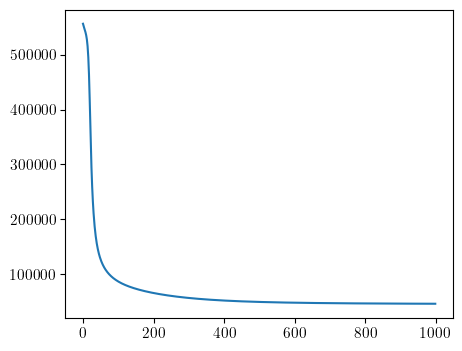

In [37]:
plt.plot(jhist)
plt.show()

In [39]:
df_to_evaluate = df_train

RMSE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2

RMSE = np.sqrt(RMSE/len(df_to_evaluate))
RMSE

np.float64(0.534938228789419)

In [38]:
df_to_evaluate = df_test

RMSE = 0
for i, row in df_to_evaluate.iterrows():
    movieId_matrix = ids["moviesIDs"][str(int(row["movieId"]))]
    userId_matrix = ids["userIDs"][str(int(row["userId"]))]
    RMSE += abs(row["rating"] - p[int(movieId_matrix), int(userId_matrix)])**2

RMSE = np.sqrt(RMSE/len(df_to_evaluate))
RMSE

np.float64(1.2221865707501178)

In [29]:
# ...

In [40]:
# procurar na net medida de avalaciao de regressoes lineares